INTRODUCTION 

Worldwide, an estimated 19.3 million new cancer cases (18.1 million excluding nonmelanoma skin cancer) and almost 10.0 million cancer deaths (9.9 million excluding nonmelanoma skin cancer) occurred in 2020. Female breast cancer has surpassed lung cancer as the most commonly diagnosed cancer, with an estimated 2.3 million new cases (11.7%), followed by lung (11.4%), colorectal (10.0 %), prostate (7.3%), and stomach (5.6%) cancers. **Lung cancer remained the leading cause of cancer death**, with an estimated 1.8 million deaths (18%), followed by colorectal (9.4%), liver (8.3%), stomach (7.7%), and female breast (6.9%) cancers.

Source: [A Cancer Journal for Physicians](https://doi.org/10.3322/caac.21660)

Access to medical facilities afflict many under developed/developing communities. The ongoing COVID-19 health crisis further taxes over-burdened healthcare systems. Despite the heavy resources being focussed on COVID-19 managmenet, lung cancer continues to afflict many worldwide and may not be picked up till Stage 3 or 4, when it is often too late for intervention. This motivates the creation of a efficient means to diagnose lung cancers to enable commencement of early intervention. 

I used EfficientNet-B4 to compare with prior work done with the the largest B7 mode. Compared with the widely used ResNet-50, EfficientNet-B4 uses similar FLOPS, while improving the top-1 accuracy from 76.3% of ResNet-50 to 82.6% (+6.3%), based on this [source](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html).

DATA

I used the [Chest CT-scan dataset from Kaggle](https://www.kaggle.com/mohamedhanyyy/chest-ctscan-images).

Dataset contains 3 cancer lung cancer types: Adenocarcinoma, Large cell carcinoma, Squamous cell carcinoma, normal, non-cancerous cells.

*Adenocarcinoma*
Adenocarcinoma of the lung: Lung adenocarcinoma is the most common form of lung cancer accounting for 30 percent of all cases overall and about 40 percent of all non-small cell lung cancer occurrences. Adenocarcinomas are found in several common cancers, including breast, prostate and colorectal.

Adenocarcinomas of the lung are found in the outer region of the lung in glands that secrete mucus and help us breathe. Symptoms include coughing, hoarseness, weight loss and weakness.

*Large cell carcinoma*
Large-cell undifferentiated carcinoma: Large-cell undifferentiated carcinoma lung cancer grows and spreads quickly and can be found anywhere in the lung. This type of lung cancer usually accounts for 10 to 15 percent of all cases of NSCLC. Large-cell undifferentiated carcinoma tends to grow and spread quickly.

*Squamous cell carcinoma*
Squamous cell: This type of lung cancer is found centrally in the lung, where the larger bronchi join the trachea to the lung, or in one of the main airway branches. Squamous cell lung cancer is responsible for about 30 percent of all non-small cell lung cancers, and is generally linked to smoking.


Check that runtime is connected to a GPU

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Sat May 15 12:40:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

Setup prequisite packages

In [ ]:
pip install graphviz

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

Download data from dropbox

In [ ]:
!wget -qq https://www.dropbox.com/s/8ib8mcjhoqdos7e/ChestData.zip

!ls
!unzip -qq ChestData.zip
!rm ChestData.zip

 ChestData.zip	'ChestData.zip?dl=0'  'ChestData.zip?dl=0.1'   sample_data


In [ ]:
!ls ChestData # check folder names in ChestData dataset

test  train  valid


In [ ]:
!ls ChestData/valid

adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
normal
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=270,
        width_shift_range=0.5,
        height_shift_range=0.5,
        shear_range=0.5,
        zoom_range=0.5,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

Setting up data pipeline

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = './ChestData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

# a good reference to flow_from_directory : https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

Found 613 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = './ChestData//valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 72 images belonging to 4 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = './ChestData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 315 images belonging to 4 classes.


EfficientNet B4

Reference:
https://www.kaggle.com/yasserhessein/chest-cancer-classification-efficientnetb7 

In [ ]:
base_model = tf.keras.applications.EfficientNetB4(input_shape=(224,224,3),include_top=False,weights="imagenet")

In [ ]:
# Freeze Layers

for layer in base_model.layers[:-8]:
    layer.trainable=False

In [ ]:
# Build Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 7, 7, 1792)        17673823  
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 1792)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 87808)             0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 87808)             351232    
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2809888   
_________________________________________________________________
batch_normalization_21 (Batc (None, 32)                128       
_________________________________________________________________
activation_15 (Activation)   (None, 32)               

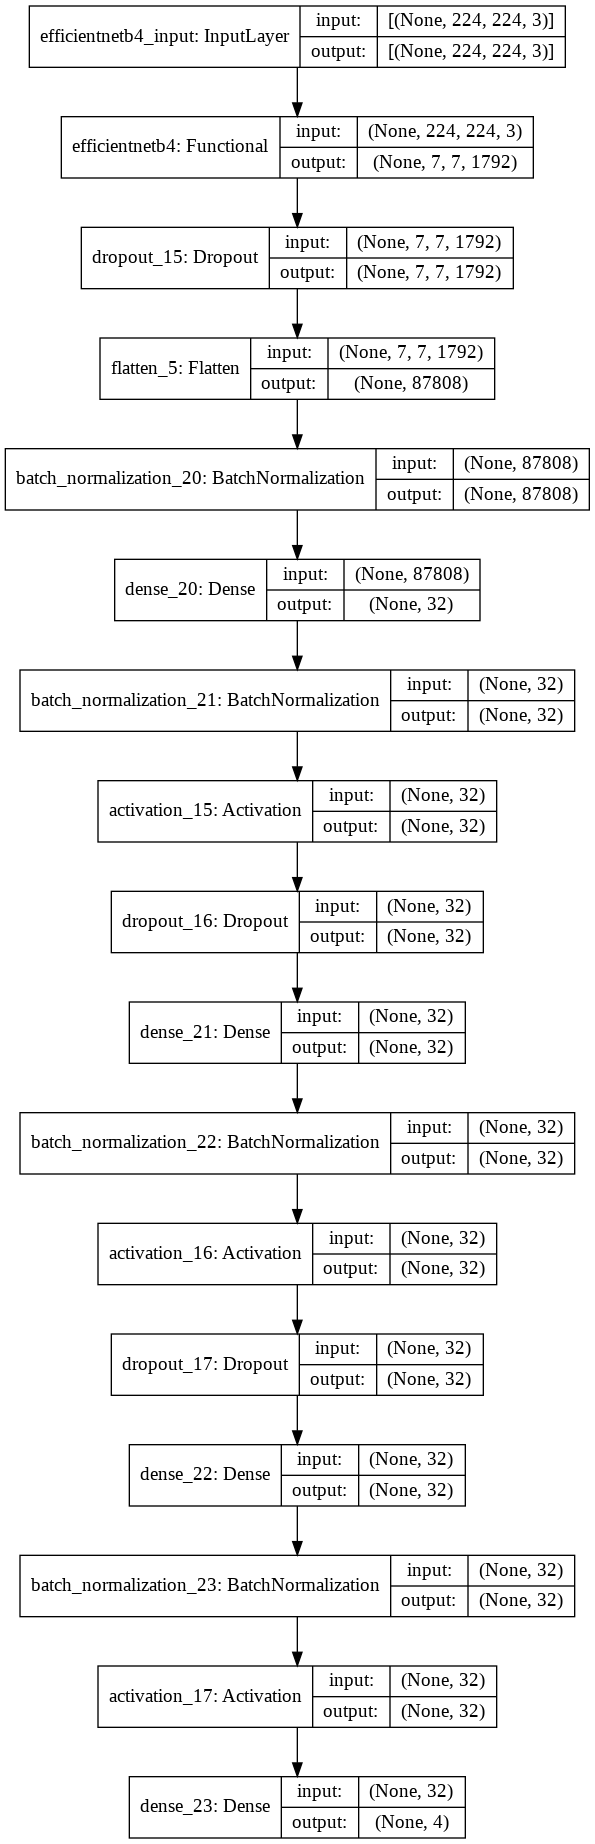

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 2,verbose = 1,factor = 0.20, min_lr = 1e-5) # readme here - https://keras.io/api/callbacks/reduce_lr_on_plateau/

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=3, patience=3)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

TRAIN & EVALUATE MODEL - EFFICIENTNET B4

In [ ]:
%time
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Epoch 1/20
10/10 [==============================] - 24s 1s/step - loss: 1.5922 - accuracy: 0.7210 - precision: 0.3000 - recall: 0.0885 - auc: 0.5199 - f1_score: 0.1306 - val_loss: 1.5582 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5259 - val_f1_score: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 10s 1s/step - loss: 1.6061 - accuracy: 0.7201 - precision: 0.2032 - recall: 0.0411 - auc: 0.4859 - f1_score: 0.0678 - val_loss: 1.3957 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5180 - val_f1_score: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 10s 1s/step - loss: 1.5116 - accuracy: 0.7379 - precision: 0.3647 - recall: 0.0638 - auc: 0.5315 - f1_score: 0.1075 - val_loss: 1.3786 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5530 - val_f1_score: 0.0000e+00
Epoch 4/20
1

In [ ]:
model.evaluate(test_dataset, verbose=1)

5/5 [==============================] - 2s 398ms/step - loss: 1.3641 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5875 - f1_score: 0.0000e+00


[1.3641473054885864, 0.75, 0.0, 0.0, 0.58745276927948, 0.0]

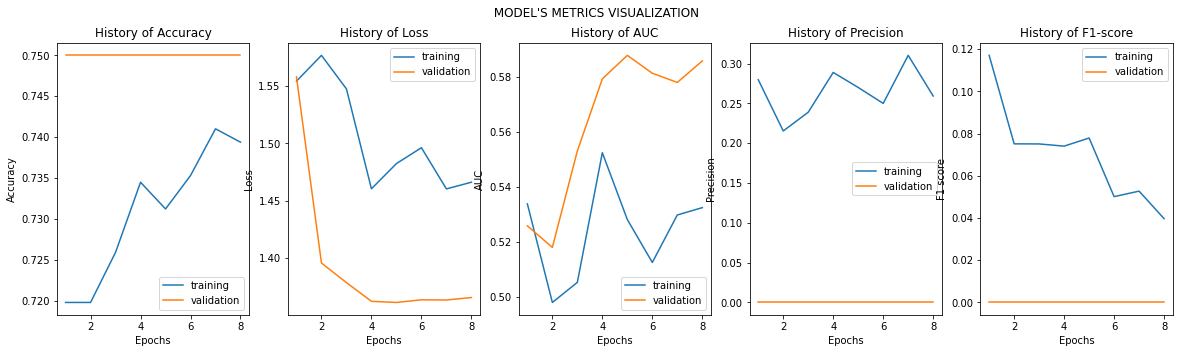

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )